# Micro-Mechanical Tensile and Shear Tests on Tissue Slices of Norway Spruce
This Notebook allows to manipulate and plot the data contained in *Tensile_Shear_Tests_Dataset*. The dataset presents experimental results from tensile (UTS) and shear (USS) tests performed on tissue slices of Norway Spruce, tested across different anatomical orientations - longitudinal (L), radial (R), and tangential (T) - and at varying relative humidity (RH) levels of 30%, 65%, and 90%. The tissue samples were sliced in all orientations: {LR, RL, RT, TR, LT, TL}, where the first letter indicates the longest dimension and the second represents the width. {LR,RL,RT,TR} are characterized by alternating bands of earlywood (EW) and latewood (LW). For {LT,TL}, different tissues were isolated for EW and LW: {LT-EW, LT-LW, TL-EW, TL-LW}.

The dataset is organized by sample and test type, with each file containing multiple sheets - one for each sample. Each sheet provides detailed information about the sample, including its dimensions, RH during testing, failure stress (maximum recorded stress), and elastic modulus (Young’s or shear modulus). The modulus is calculated from a linear fit of the stress-strain curve within a range of 10% to 60% of the strain corresponding to the ultimate strength, and the specific range used for this calculation is provided in each sheet. Additionally, each sheet contains recorded time, elongation, and force, along with strain and stress values calculated from these measurements and the sample dimensions.

## Data path and imports
Set the **path to the folder** containing the Excel files to enable proper data access and then run the next section to import the required libraries that provide the necessary functions and tools for data manipulation and visualization throughout this notebook. 

In [17]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set path to folder
folder_path = '/home/aferrara/Desktop/microstage-evaluation-routine/Tensile_Shear_Tests_Dataset'


## Custom functions
Run this section to make the custom functions available for use in the rest of the notebook.

In [22]:
# Functions
# Convert strings to floats, handling apostrophes
def safe_float_conversion(value):
    try:
        return float(str(value).replace("'", "").strip())
    except ValueError:
        return None

# Load data from a specific sheet
def load_sheet_data(sheet_name, xls):
    df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=10)
    metadata_df = pd.read_excel(xls, sheet_name=sheet_name, nrows=11, header=None)
    metadata = {
        'RH [%]': safe_float_conversion(metadata_df.iloc[2, 1]),  # Relative Humidity
        'Start fitting [%]': safe_float_conversion(metadata_df.iloc[9, 1]),  # Start of fitting region
        'End fitting [%]': safe_float_conversion(metadata_df.iloc[10, 1])  # End of fitting region
    }
    df.columns = ['Time', 'Elongation', 'Strain', 'Force', 'Stress']  
    df['Strain'] = pd.to_numeric(df['Strain'], errors='coerce')
    df['Stress'] = pd.to_numeric(df['Stress'], errors='coerce')
    
    # Calculate the maximum stress
    max_stress = df['Stress'].max()
    
    return metadata, df, max_stress

# Get a list of Excel file paths from the specified folder
def get_excel_file_paths(folder_path):
    return [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith(('.xlsx', '.xls'))]

# Load data from multiple excel files
def load_excel_data(file_paths):
    
    sheet_info = {}
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        test_type, sample_type = file_name.split('_')[:2]  # Get test type and sample type

        # Load the Excel file
        xls = pd.ExcelFile(file_path)       
        for sheet in xls.sheet_names:
            rh_value = safe_float_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[2, 1])
            
            # Store RH values associated with test type and sample type
            if test_type not in sheet_info:
                sheet_info[test_type] = {}
            if sample_type not in sheet_info[test_type]:
                sheet_info[test_type][sample_type] = set()
            sheet_info[test_type][sample_type].add(rh_value)
    
    return sheet_info

# Create dropdown widgets (test type, sample type, RH, samples) for plot selection 
def create_dropdown_widget_sample(folder_path):
    
    excel_file_paths = get_excel_file_paths(folder_path)
    sheet_info = load_excel_data(excel_file_paths)

    # Initialize widgets
    test_type_dropdown = widgets.Dropdown(options=list(sheet_info.keys()), description='Test Type:', disabled=False)
    sample_type_dropdown = widgets.Dropdown(description='Sample Type:', disabled=False)
    rh_dropdown = widgets.Dropdown(description='RH [%]:', disabled=False)
    sheet_dropdown = widgets.Dropdown(description='Sample:', disabled=False)

    def initialize_selections():
        # Initialize selections and update dropdowns
        current_test_type = test_type_dropdown.options[0]  # Get the first test type
        test_type_dropdown.value = current_test_type
        current_sample_type = list(sheet_info[current_test_type].keys())[0]  # Get the first sample type
        sample_type_dropdown.options = list(sheet_info[current_test_type].keys())  # Set sample type options
        sample_type_dropdown.value = current_sample_type  # Set initial sample type
        update_rh_values(current_test_type, current_sample_type)  # Initialize RH values

    def update_sample_types(change):
        # Update sample types based on selected test type
        selected_test_type = change['new']
        sample_types = list(sheet_info[selected_test_type].keys())
        sample_type_dropdown.options = sample_types  # Update sample type options
        
        # Retain valid sample type or reset to first
        sample_type_dropdown.value = sample_types[0] if sample_types else None

        # Update RH values for the newly selected sample type
        update_rh_values(selected_test_type, sample_type_dropdown.value)

    def update_rh_values(selected_test_type, selected_sample_type):
        # Update RH values based on selected test and sample types
        if selected_sample_type:
            rh_values = list(sheet_info[selected_test_type][selected_sample_type])
            rh_dropdown.options = rh_values
            
            # Reset RH selection if current value is not valid
            if rh_dropdown.value not in rh_values:
                rh_dropdown.value = rh_values[0] if rh_values else None

            # Update sheet options based on current selections
            update_sheet_options(selected_test_type, selected_sample_type, rh_dropdown.value)

    def update_sheet_options(selected_test_type, selected_sample_type, selected_rh):
        # Update available sheet options based on selected test and sample types, filtered by RH
        available_sheets = []
        
        # Iterate through all Excel files to find matching sheets
        for file_path in excel_file_paths:
            file_name = os.path.basename(file_path)
            file_test_type, file_sample_type = file_name.split('_')[:2]
            
            # Check if file matches selected test type and sample type
            if file_test_type == selected_test_type and file_sample_type == selected_sample_type:
                xls = pd.ExcelFile(file_path)
                for sheet in xls.sheet_names:
                    # Check the RH value for the sheet
                    sheet_rh = safe_float_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[2, 1])
                    if sheet_rh == selected_rh:
                        available_sheets.append(sheet)
        
        # Update sheet dropdown with unique options
        sheet_dropdown.options = list(set(available_sheets))
        sheet_dropdown.value = sheet_dropdown.options[0] if sheet_dropdown.options else None

        # Update plot if all values are valid
        if selected_test_type and selected_sample_type and selected_rh is not None and sheet_dropdown.value is not None:
            update_plot(selected_test_type, selected_sample_type, selected_rh, sheet_dropdown.value)

    def update_plot(selected_test_type, selected_sample_type, selected_rh, selected_sheet):
        # Clear the output and plot the selected sheet
        clear_output(wait=True)
        display(test_type_dropdown, sample_type_dropdown, rh_dropdown, sheet_dropdown)

        if selected_test_type and selected_sample_type and selected_rh is not None and selected_sheet is not None:
            # Find the correct file path for the selected test and sample type
            for file_path in excel_file_paths:
                file_name = os.path.basename(file_path)
                file_test_type, file_sample_type = file_name.split('_')[:2]

                if file_test_type == selected_test_type and file_sample_type == selected_sample_type:
                    plot_stress_strain_curve(selected_test_type, round(selected_rh), selected_sheet, pd.ExcelFile(file_path))  # Plot the selected sheet
                    break
            else:
                print("No valid file found for the selected test type and sample type.")  # Handle case if no valid file

    # Observe changes in dropdowns
    test_type_dropdown.observe(update_sample_types, names='value')
    sample_type_dropdown.observe(lambda change: update_rh_values(test_type_dropdown.value, change['new']), names='value')
    rh_dropdown.observe(lambda change: update_sheet_options(test_type_dropdown.value, sample_type_dropdown.value, change['new']), names='value')
    sheet_dropdown.observe(lambda change: update_plot(test_type_dropdown.value, sample_type_dropdown.value, rh_dropdown.value, change['new']), names='value')

    display(test_type_dropdown, sample_type_dropdown, rh_dropdown, sheet_dropdown)
    initialize_selections()

# Plot stress-strain curve with linear fitting
def plot_stress_strain_curve(test_type, rh_value, sheet_name, xls):

    metadata, data, _ = load_sheet_data(sheet_name, xls)

    data = data[pd.notnull(data['Stress'])]
    max_stress_index = data['Stress'].idxmax()
    data = data.iloc[:max_stress_index]
    
    # Extract relevant information for fitting
    start_fitting = metadata['Start fitting [%]']*data['Strain'].iloc[-1]/100
    end_fitting = metadata['End fitting [%]']*data['Strain'].iloc[-1]/100

    # Filter data based on the fitting region, ignoring NaN values
    fitting_data = data[(data['Strain'] >= start_fitting) & (data['Strain'] <= end_fitting)].dropna()
    
    if fitting_data.empty:
        print(f"No data points found in the fitting range ({start_fitting*100}%-{end_fitting*100}%) for sheet '{sheet_name}'.")
        return
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(fitting_data['Strain'], fitting_data['Stress'])
    
    # Generate the fitted curve using the entire data range
    fitted_stress = slope * data['Strain'] + intercept

    # Plot original Stress vs. Strain curve
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(data['Strain'], data['Stress'], label='Original Data', color='blue')
    
    # Plot the fitted line only within the range of original data
    ax.plot(data['Strain'], fitted_stress, label=f'Linear Fitting (Slope = {slope:.2f})', color='red')
    
    # Highlight the fitting region
    ax.axvspan(start_fitting, end_fitting, color='yellow', alpha=0.3, label='Fitting Region')
    # Enable grid
    ax.grid(color='gray', linewidth=0.2)
    # Set tick parameters for both axes
    tick_label_font_size = 12  # Font size for tick labels
    ax.tick_params(axis='both', labelsize=tick_label_font_size)
    # Set plot title and labels
    title_font_size = 16  # Font size for title
    label_font_size = 14   # Font size for labels
    ax.set_title(f"{test_type} - {rh_value}% RH - {sheet_name}",fontsize=title_font_size)
    ax.set_xlabel("Strain [-]",fontsize=label_font_size)
    ax.set_ylabel("Stress [MPa]",fontsize=label_font_size)
    # Position legend outside the plot area
    legend_font_size = 10  # Font size for legend
    ax.legend(loc='lower right', prop={'size': legend_font_size}) 
    # Adjust layout to optimize space between plot and legend
    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)
    
    # Show the plot
    plt.show()

# Create dropdown widgets (test type, sample type, RH) for plot selection 
def create_dropdown_widget(folder_path):

    excel_file_paths = get_excel_file_paths(folder_path)
    sheet_info = load_excel_data(excel_file_paths)
    print(sheet_info)

    # Initialize widgets
    test_type_dropdown = widgets.Dropdown(options=list(sheet_info.keys()), description='Test Type:', disabled=False)
    sample_type_dropdown = widgets.Dropdown(description='Sample Type:', disabled=False)
    rh_dropdown = widgets.Dropdown(description='RH [%]:', disabled=False)

    current_sample_type = None

    def initialize_selections():
        current_test_type = test_type_dropdown.options[0]  # Get the first test type
        test_type_dropdown.value = current_test_type
        current_sample_type = list(sheet_info[current_test_type].keys())[0]  # Get the first sample type
        sample_type_dropdown.options = list(sheet_info[current_test_type].keys())  # Set sample type options
        sample_type_dropdown.value = current_sample_type  # Set initial sample type
        update_rh_values(current_test_type, current_sample_type)  # Initialize RH values

    def update_sample_types(change):
        nonlocal current_sample_type
        selected_test_type = change['new']
        sample_types = list(sheet_info[selected_test_type].keys())
        sample_type_dropdown.options = sample_types  # Update sample type options

        if current_sample_type in sample_types:
            sample_type_dropdown.value = current_sample_type  # Retain valid sample type
        else:
            current_sample_type = sample_types[0] if sample_types else None  # Reset to the first option if not valid
            sample_type_dropdown.value = current_sample_type

        update_rh_values(selected_test_type, sample_type_dropdown.value)

    def update_rh_values(selected_test_type, selected_sample_type):
        if selected_sample_type:
            rh_values = list(sheet_info[selected_test_type][selected_sample_type])
            rh_dropdown.options = rh_values
            
            if rh_dropdown.value not in rh_values:
                rh_dropdown.value = rh_values[0] if rh_values else None

        if selected_test_type and selected_sample_type and rh_dropdown.value is not None:
            update_plot(selected_test_type, selected_sample_type, rh_dropdown.value)

    def update_plot(selected_test_type, selected_sample_type, selected_rh):
        clear_output(wait=True)
        display(test_type_dropdown, sample_type_dropdown, rh_dropdown)

        if selected_test_type and selected_sample_type and selected_rh is not None:
            plot_all_curves(selected_test_type, selected_sample_type, round(selected_rh), excel_file_paths)

    test_type_dropdown.observe(update_sample_types, names='value')
    sample_type_dropdown.observe(lambda change: update_rh_values(test_type_dropdown.value, change['new']), names='value')
    rh_dropdown.observe(lambda change: update_plot(test_type_dropdown.value, sample_type_dropdown.value, change['new']), names='value')

    display(test_type_dropdown, sample_type_dropdown, rh_dropdown)

    initialize_selections()

# Plot stress-strain curves sorted by test type, sample type and RH
def plot_all_curves(test_type, sample_type, rh_value, file_paths):
    
    # Close all previous figures before starting a new plot
    plt.close('all')  
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        file_test_type, file_sample_type = file_name.split('_')[:2]
        
        if file_test_type == test_type and file_sample_type == sample_type:
            xls = pd.ExcelFile(file_path)
            
            for sheet in xls.sheet_names:
                sheet_rh = safe_float_conversion(pd.read_excel(xls, sheet_name=sheet, header=None).iloc[2, 1])                
                if sheet_rh == rh_value:
                    # Load datasets
                    metadata, data, _ = load_sheet_data(sheet, xls)
                    # Get rid of data after rupture
                    data = data[pd.notnull(data['Stress'])]
                    max_stress_index = data['Stress'].idxmax()
                    data = data.iloc[:max_stress_index]                   
                    # Extract range for fitting
                    start_fitting = metadata['Start fitting [%]']*data['Strain'].iloc[-1]/100
                    end_fitting = metadata['End fitting [%]']*data['Strain'].iloc[-1]/100
                    # Filter data based on the fitting region, ignoring NaN values
                    fitting_data = data[(data['Strain'] >= start_fitting) & (data['Strain'] <= end_fitting)].dropna()
                    # Plot data
                    line, = ax.plot(data['Strain'], data['Stress'], label=f"{sheet} - Original Data", linestyle='-')
                    line_color = line.get_color()               
                    if not fitting_data.empty:
                        slope, intercept, _, _, _ = linregress(fitting_data['Strain'], fitting_data['Stress'])
                        fitted_stress = slope * data['Strain'] + intercept                       
                        # Plot fitted line
                        ax.plot(data['Strain'], fitted_stress, linestyle='--', color=line_color, label=f"{sheet} - Fitting")
    
    # Enable grid
    ax.grid(color='gray', linewidth=0.2)
    # Set tick parameters for both axes
    tick_label_font_size = 12  # Font size for tick labels
    ax.tick_params(axis='both', labelsize=tick_label_font_size)
    # Set plot title and labels
    title_font_size = 16  # Font size for title
    label_font_size = 14   # Font size for labels
    ax.set_title(f"{test_type} - {sample_type} samples - {rh_value}% RH",fontsize=title_font_size)
    ax.set_xlabel("Strain [-]",fontsize=label_font_size)
    ax.set_ylabel("Stress [MPa]",fontsize=label_font_size)
    # Position legend outside the plot area
    legend_font_size = 10  # Font size for legend
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,prop={'size': legend_font_size}) 
    # Adjust layout to optimize space between plot and legend
    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)

    plt.gcf().canvas.manager.set_window_title('')

    # Display the plot
    plt.show()

# 
def summarize_max_stress(folder_path):
    excel_file_paths = get_excel_file_paths(folder_path)
    summary_data = []

    for file_path in excel_file_paths:
        file_name = os.path.basename(file_path)
        test_type, sample_type = file_name.split('_')[:2]  # Get test type and sample type

        # Load the Excel file
        xls = pd.ExcelFile(file_path)
        
        for sheet in xls.sheet_names:
            metadata, data, max_stress = load_sheet_data(sheet, xls)

            # Extract relevant data
            rh_value = metadata['RH [%]']
            summary_data.append((test_type, sample_type, rh_value, max_stress))

    # Convert to DataFrame for analysis
    summary_df = pd.DataFrame(summary_data, columns=['Test Type', 'Sample Type', 'RH [%]', 'Ultimate Stress'])
    
    # Group by Test Type, Sample Type, and RH to calculate average and confidence interval
    summary_stats = summary_df.groupby(['Test Type', 'Sample Type', 'RH [%]']).agg(
        Average_Max_Stress=('Max Stress', 'mean')).reset_index()

    # Calculate 95% confidence interval
    summary_stats['Error'] = 1.96 * (summary_stats['Std_Dev'] / summary_stats['Count'] ** 0.5)
    #summary_stats['Lower_CI'] = summary_stats['Average_Max_Stress'] - summary_stats['Margin_of_Error']
    #summary_stats['Upper_CI'] = summary_stats['Average_Max_Stress'] + summary_stats['Margin_of_Error']
    
    return summary_stats

def display_summary_table(folder_path):
    summary_stats = summarize_max_stress(folder_path)
    print(summary_stats)
    return summary_stats



In [23]:
summary_table = display_summary_table(folder_path)


KeyError: "Column(s) ['Max Stress'] do not exist"

## Plot stress-strain curve of a sample
Run the following section to set up an interactive interface to plot the stress-strain curve of a specific sample. The interface provides 4 dropdown menus that allow you to customize the plot:

- **Test Type** lists the available test types, namely **Tensile Test (UTS)** and **Shear Test (USS)**.

- **Sample Type** lists the different sample types you can choose from, such as **LT-EW**, **LT-LW**, **LR**, **RL**, **RT**, **TR**, and **TL-LW**.

- **RH [%]** lists the relative humidity values available for selection: **30%**, **65%**, and **90%**.

- **Sample** lists the available samples filtered by **Test Type**, **Sample Type**, and **RH**.

After selecting a sample from a combination of test type, sample type, and RH value, the corresponding stress-strain curve is plotted along with the calculated linear fitting.


Dropdown(description='Test Type:', index=1, options=('USS', 'UTS'), value='UTS')

Dropdown(description='Sample Type:', options=('RL', 'LT-EW', 'RT', 'LT-LW', 'TR', 'LR', 'TL-LW', 'TL-EW'), val…

Dropdown(description='RH [%]:', index=1, options=(65.0, 90.0, 30.0), value=90.0)

Dropdown(description='Sample:', index=7, options=('1-mRL1-46-30', '1-mRL1-32-7', '1-mRL1-32-3', '1-mRL1-46-28'…

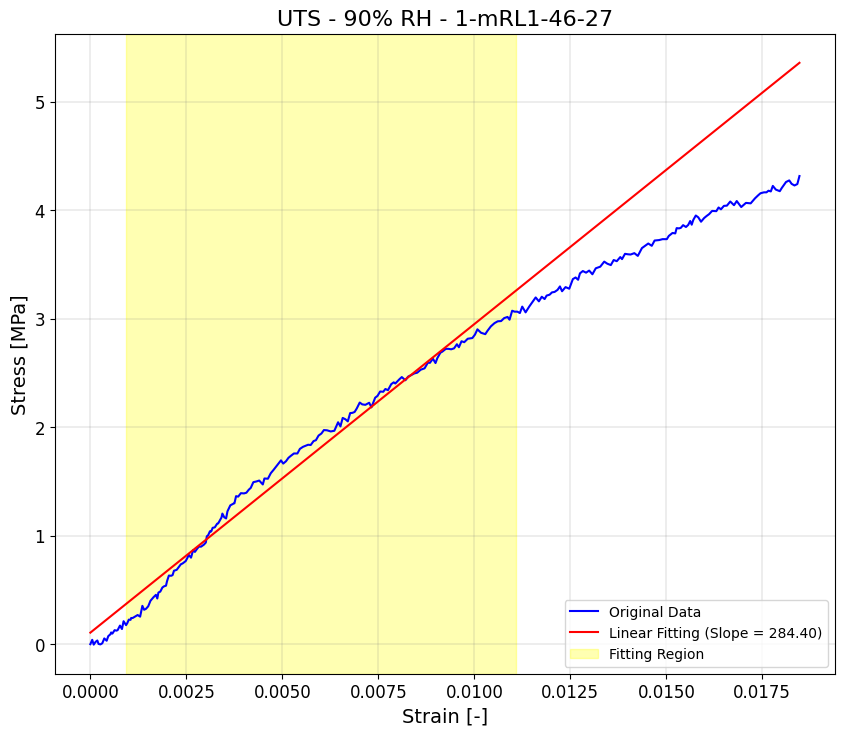

In [ ]:
create_dropdown_widget_sample(folder_path)

## Plot stress-strain curves sorted by test type, sample type, and RH
Run the following section to set up an interactive interface for visualizing multiple stress-strain curves, organized by test type, sample type, and RH. The interface provides 3 dropdown menus that allow you to customize the plot:

- **Test Type** lists the available test types, namely **Tensile Test (UTS)** and **Shear Test (USS)**.

- **Sample Type** lists the different sample types you can choose from, such as **LT-EW**, **LT-LW**, **LR**, **RL**, **RT**, **TR**, and **TL-LW**.

- **RH [%]** lists the relative humidity values available for selection: **30%**, **65%**, and **90%**.

After selecting a combination of test type, sample type, and RH value, the corresponding stress-strain curves are plotted along with the calculated linear fitting.


Dropdown(description='Test Type:', options=('USS', 'UTS'), value='USS')

Dropdown(description='Sample Type:', index=5, options=('LT-EW', 'LR', 'RL', 'RT', 'TR', 'TL-EW', 'TL-LW', 'LT-…

Dropdown(description='RH [%]:', options=(65.0, 90.0, 30.0), value=65.0)

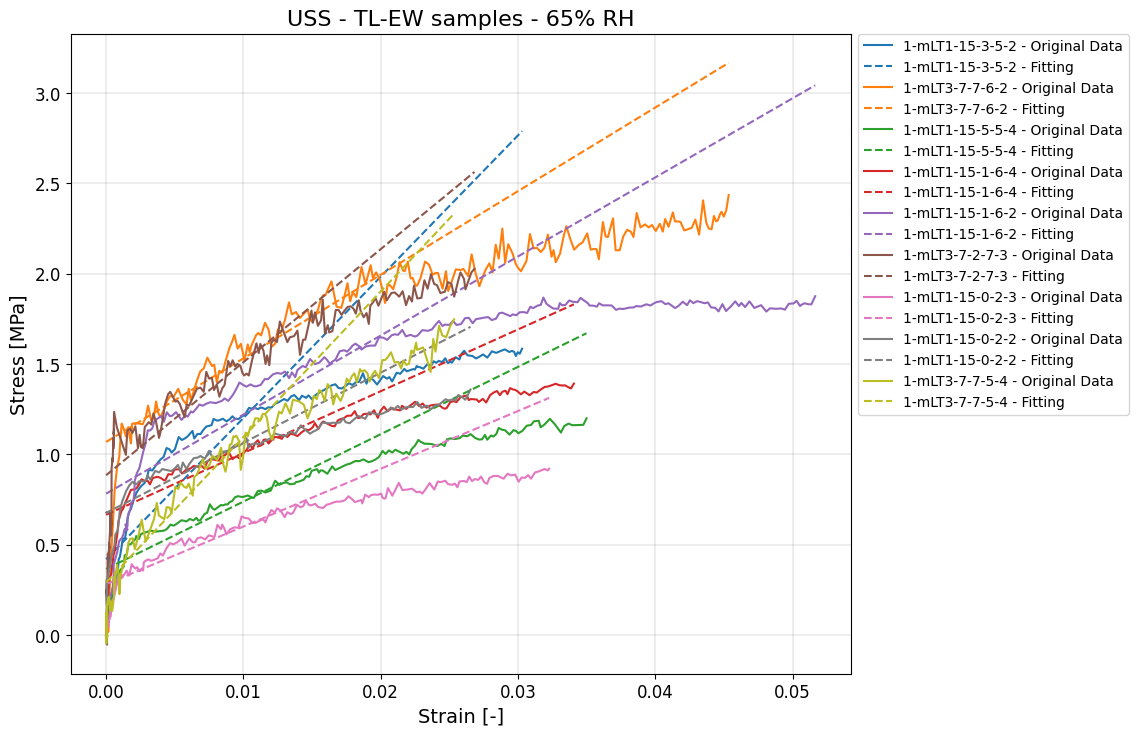

In [ ]:
create_dropdown_widget(folder_path)